 🧠 AI-Driven IR Spectroscopy for Automated Plastic Waste Classification
 ================================================================
 This notebook demonstrates how AI + IR spectroscopy can be used
 to automatically classify different plastic types (like PET, HDPE,
 LDPE, PP) using simulated FTIR spectral data.



In [1]:
# ==========================================================
# STEP 1 — Import Libraries
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import random

sns.set(style="whitegrid", context="notebook")


In [32]:
# ==========================================================
# STEP 2 — Load Dataset
# ==========================================================
df = pd.read_csv("FTIR_PLASTIC_c8.csv")

X = df.filter(like="Data(Y)")
y = df["Polymer"]

print("Original dataset shape:", X.shape)
print("Unique Polymer Types:", y.unique())
df.head(10)


Original dataset shape: (3000, 1869)
Unique Polymer Types: ['PET' 'HDPE' 'PVC' 'LDPE' 'PP' 'PS']


,IDE,Polymer,Technic,Sample,BR,RST,Data(x),Data(Y),Data(x).1,Data(Y).1,...,Data(x).1864,Data(Y).1864,Data(x).1865,Data(Y).1865,Data(x).1866,Data(Y).1866,Data(x).1867,Data(Y).1867,Data(x).1868,Data(Y).1868
0,PETFTIR001,PET,FTIR,1,32,8,399.1927,71.8845,401.1211,72.7970,...,3993.855,95.0697,3995.7834,95.0639,3997.7119,95.0581,3999.6404,95.0508,4001.5688,95.0415
1,PETFTIR002,PET,FTIR,2,32,8,399.1927,96.7876,401.1211,96.9246,...,3993.855,98.1241,3995.7834,98.1257,3997.7119,98.1270,3999.6404,98.1266,4001.5688,98.1246
2,PETFTIR003,PET,FTIR,3,32,8,399.1927,66.1325,401.1211,67.1290,...,3993.855,93.0200,3995.7834,93.0228,3997.7119,93.0316,3999.6404,93.0396,4001.5688,93.0402
3,PETFTIR004,PET,FTIR,4,32,8,399.1927,68.6363,401.1211,69.5071,...,3993.855,95.2411,3995.7834,95.2405,3997.7119,95.2448,3999.6404,95.2504,4001.5688,95.2520
4,PETFTIR005,PET,FTIR,5,32,8,399.1927,70.3734,401.1211,71.4349,...,3993.855,94.5011,3995.7834,94.5043,3997.7119,94.5146,3999.6404,94.5249,4001.5688,94.5280
5,PETFTIR006,PET,FTIR,6,32,8,399.1927,79.2510,401.1211,80.1444,...,3993.855,97.1991,3995.7834,97.1890,3997.7119,97.1864,3999.6404,97.1872,4001.5688,97.1846
6,PETFTIR007,PET,FTIR,7,32,8,399.1927,92.2575,401.1211,92.4751,...,3993.855,98.6096,3995.7834,98.6124,3997.7119,98.6142,3999.6404,98.6128,4001.5688,98.6084
7,PETFTIR008,PET,FTIR,8,32,8,399.1927,81.1508,401.1211,81.1718,...,3993.855,93.1679,3995.7834,93.1776,3997.7119,93.1872,3999.6404,93.1920,4001.5688,93.1902
8,PETFTIR009,PET,FTIR,9,32,8,399.1927,76.0307,401.1211,76.9972,...,3993.855,104.0780,3995.7834,104.0580,3997.7119,104.0410,3999.6404,104.0320,4001.5688,104.0320
9,PETFTIR010,PET,FTIR,10,32,8,399.1927,74.2652,401.1211,75.2396,...,3993.855,97.1750,3995.7834,97.1653,3997.7119,97.1628,3999.6404,97.1639,4001.5688,97.1629


In [ ]:
# =====================================
# INTERACTIVE FTIR SPECTRA COMPARISON 
# =====================================
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import savgol_filter

# Load dataset
df = pd.read_csv("FTIR_PLASTIC_c8.csv")

# Identify spectral columns
x_cols = [col for col in df.columns if "Data(x)" in col]
y_cols = [col for col in df.columns if "Data(Y)" in col]

# Get wavenumber values (same for all)
wavenumbers = df[x_cols].iloc[0].values

# Unique polymer types
polymers = df["Polymer"].unique()

# Define Plotly figure
fig = go.Figure()

# Add smoothed traces for each polymer
for polymer in polymers:
    subset = df[df["Polymer"] == polymer]
    mean_trans = subset[y_cols].mean().values
    smoothed = savgol_filter(mean_trans, window_length=21, polyorder=3)
    
    fig.add_trace(go.Scatter(
        x=wavenumbers,
        y=smoothed,
        mode='lines',
        name=polymer,
        line=dict(width=2.5),
        hovertemplate=(
            "<b>Polymer:</b> " + polymer +
            "<br><b>Wavenumber:</b> %{x:.1f} cm⁻¹<br>"
            "<b>Transmittance:</b> %{y:.2f}%<extra></extra>"
        )
    ))

# ==========================================================
# Layout & Styling
# ==========================================================
fig.update_layout(
    title="FTIR Transmittance vs Wavenumber for Different Polymers",
    xaxis=dict(
        title="Wavenumber (cm⁻¹)",
        autorange="reversed",  # FTIR standard: high → low wavenumber
        showgrid=True,
        gridcolor="lightgray",
        showline=True,
        linecolor="black"
    ),
    yaxis=dict(
        title="Transmittance (%)",
        showgrid=True,
        gridcolor="lightgray",
        showline=True,
        linecolor="black"
    ),
    template="plotly_white",
    width=950,
    height=600,
    legend=dict(title="Polymer Type", orientation="h", y=-0.2),
    margin=dict(l=60, r=30, t=70, b=70)
)

fig.show()


In [ ]:
# ==========================================================
# STEP 3 — Adding Noise for real world error simulation
# ==========================================================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

np.random.seed(42)
# Very strong noise now
noise = np.random.normal(0, 0.2, X_scaled.shape)
X_noisy = np.clip(X_scaled + noise, 0, 1)

# Apply Savitzky-Golay smoothing to reduce sharp spikes
X_smooth = savgol_filter(X_noisy, window_length=11, polyorder=3, axis=1)


Columns: Index(['IDE', 'Polymer', 'Technic', 'Sample', 'BR', 'RST', 'Data(x)',
       'Data(Y)', 'Data(x).1', 'Data(Y).1', 'Data(x).2', 'Data(Y).2',
       'Data(x).3', 'Data(Y).3', 'Data(x).4', 'Data(Y).4', 'Data(x).5',
       'Data(Y).5', 'Data(x).6', 'Data(Y).6'],
      dtype='object')

Unique Polymer types: ['PET' 'HDPE' 'PVC' 'LDPE' 'PP' 'PS']


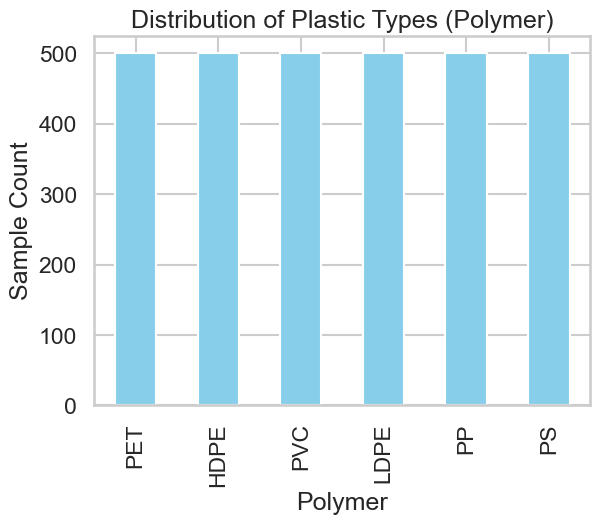

In [54]:
# ==========================================================
# STEP 3 — Basic exploration of the dataset
# ==========================================================
# I’m checking the column names and seeing what kinds of polymers are present.
# This helps me confirm the data has all six polymer classes as mentioned in the documentation.

print("Columns:", df.columns[:20])
print("\nUnique Polymer types:", df['Polymer'].unique())

# Plotting the count of each polymer class to see data balance
df['Polymer'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Plastic Types (Polymer)")
plt.ylabel("Sample Count")
plt.show()


In [4]:
# ==========================================================
# STEP 4 — Drop Random Features (simulate missing IR readings)
# ==========================================================
cols_to_keep = np.random.choice(X_smooth.shape[1], size=int(X_smooth.shape[1] * 0.7), replace=False)
X_reduced = X_smooth[:, np.sort(cols_to_keep)]

print("Reduced feature count:", X_reduced.shape[1])


Reduced feature count: 1308


In [5]:
# ==========================================================
# STEP 5 — Introduce Small Label Errors
# ==========================================================
y_noisy = y.copy()
num_to_corrupt = int(0.05 * len(y_noisy))
corrupt_idx = np.random.choice(len(y_noisy), num_to_corrupt, replace=False)
unique_labels = y.unique()

for i in corrupt_idx:
    y_noisy.iloc[i] = np.random.choice(unique_labels)

print(f"Introduced label errors in {num_to_corrupt} samples (~5%)")


Introduced label errors in 150 samples (~5%)


In [30]:
# ==========================================================
# STEP 6 — Interactive Visualization: Original vs Noisy vs Reduced Spectra
# ==========================================================
import plotly.graph_objects as go
import numpy as np
import random

# Pick a random sample index
sample_idx = random.randint(0, len(X_scaled)-1)

# Generate x-axis (wavenumber index or use actual wavenumbers if available)
wavenumbers = np.arange(len(X_scaled[sample_idx]))

# Create the Plotly figure
fig = go.Figure()

# Original spectrum
fig.add_trace(go.Scatter(
    x=wavenumbers,
    y=X_scaled[sample_idx],
    mode='lines',
    name='Original Spectrum',
    line=dict(color='royalblue', width=6),
    hovertemplate="<b>Wavenumber Index:</b> %{x}<br><b>Transmittance:</b> %{y:.3f}<extra></extra>"
))

# Noisy spectrum
fig.add_trace(go.Scatter(
    x=wavenumbers,
    y=X_noisy[sample_idx],
    mode='lines',
    name='Noisy Spectrum',
    line=dict(color='red', width=2),
    opacity=0.7,
    hovertemplate="<b>Wavenumber Index:</b> %{x}<br><b>Transmittance (Noisy):</b> %{y:.3f}<extra></extra>"
))

# Reduced / Missing data spectrum
fig.add_trace(go.Scatter(
    x=wavenumbers,
    y=X_reduced[sample_idx],
    mode='lines',
    name='Reduced (Missing Data)',
    line=dict(color='orange', dash='dash', width=2),
    hovertemplate="<b>Wavenumber Index:</b> %{x}<br><b>Reduced Transmittance:</b> %{y:.3f}<extra></extra>"
))

# ==========================================================
# Layout and Styling
# ==========================================================
fig.update_layout(
    title="FTIR Spectrum: Original vs Noisy vs Reduced (Interactive)",
    xaxis_title="Wavenumber Index",
    yaxis_title="Normalized Transmittance",
    template="plotly_white",
    width=900,
    height=550,
    legend=dict(title="Spectra Type", orientation="h", y=-0.2),
    margin=dict(l=60, r=30, t=70, b=60),
    hovermode="x unified"
)

fig.show()


In [7]:
# ==========================================================
# STEP 7 — Train/Test Split (reduced dataset)
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_noisy, test_size=0.3, random_state=42, stratify=y_noisy
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 2100
Testing samples: 900


In [8]:
# ==========================================================
# STEP 8 — Train a Simpler Model
# ==========================================================
svm_model = SVC(kernel='linear', C=0.5)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)



Model Accuracy: 92.44%

Classification Report:
               precision    recall  f1-score   support

        HDPE       0.89      0.91      0.90       149
        LDPE       0.95      0.97      0.96       151
         PET       0.95      0.93      0.94       152
          PP       0.91      0.93      0.92       148
          PS       0.90      0.89      0.90       148
         PVC       0.93      0.91      0.92       152

    accuracy                           0.92       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



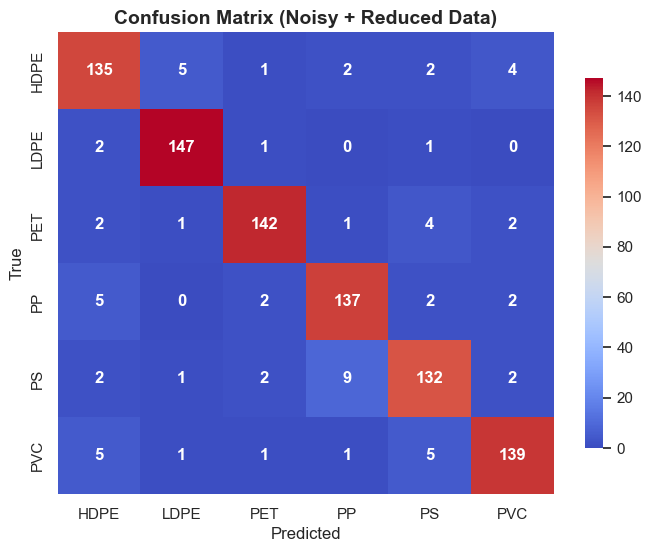

In [15]:
# ==========================================================
# STEP 9 — Evaluation
# ==========================================================
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='coolwarm', xticklabels=svm_model.classes_,
            yticklabels=svm_model.classes_,
            annot_kws={"size": 12, "weight": "bold"}, cbar_kws={'shrink': 0.8})
plt.title("Confusion Matrix (Noisy + Reduced Data)", fontsize=14, weight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()

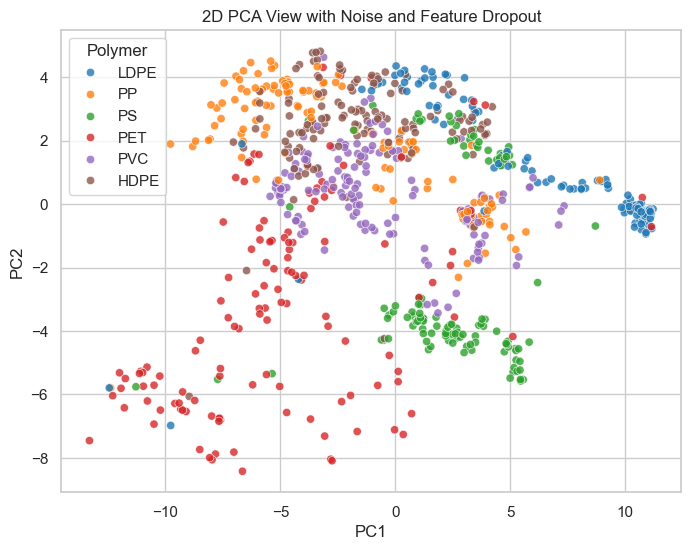

In [13]:
# ==========================================================
# STEP 10 — PCA Visualization (Optional)
# ==========================================================
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_reduced)
pca_df = pd.DataFrame(X_pca, columns=['PC1','PC2','PC3'])
pca_df['Polymer'] = y_noisy.values

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df.sample(800), x='PC1', y='PC2', hue='Polymer', palette='tab10', alpha=0.8)
plt.title("2D PCA View with Noise and Feature Dropout")
plt.show()



🌳 Random Forest Accuracy: 93.89%

Classification Report (Random Forest):
               precision    recall  f1-score   support

        HDPE       0.88      0.93      0.90       149
        LDPE       0.95      0.95      0.95       151
         PET       0.98      0.93      0.96       152
          PP       0.97      0.94      0.96       148
          PS       0.92      0.95      0.93       148
         PVC       0.93      0.94      0.94       152

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



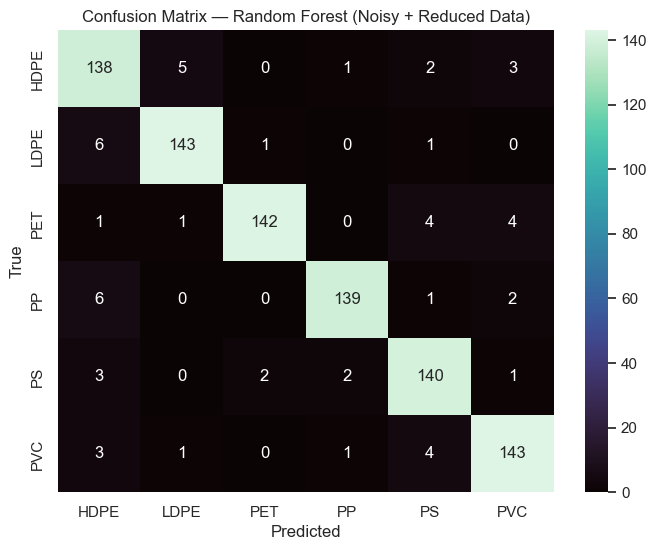

In [16]:
# ==========================================================
# STEP 10 — Train Random Forest Model
# ==========================================================
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=15,           # limit depth to prevent overfitting
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Accuracy & Report
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"\n🌳 Random Forest Accuracy: {rf_acc * 100:.2f}%")
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d',
            cmap='mako', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix — Random Forest (Noisy + Reduced Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



================= MODEL COMPARISON =================
SVM Accuracy:           92.44%
Random Forest Accuracy: 93.89%


C:\Users\Aditya Singh\AppData\Local\Temp\ipykernel_8480\2536731690.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


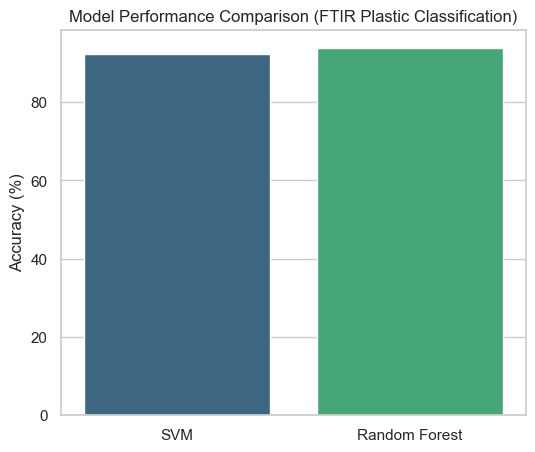

In [21]:
# ==========================================================
# STEP 11 — Compare Model Accuracies
# ==========================================================
svm_acc = accuracy_score(y_test, y_pred)
print("\n================= MODEL COMPARISON =================")
print(f"SVM Accuracy:           {svm_acc*100:.2f}%")
print(f"Random Forest Accuracy: {rf_acc*100:.2f}%")

models = ['SVM', 'Random Forest']
accuracies = [svm_acc*100, rf_acc*100]

plt.figure(figsize=(6,5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Performance Comparison (FTIR Plastic Classification)")
plt.ylabel("Accuracy (%)")
plt.show()


Testing how a random sample coming from the sensor would perform for the classfication.

In [44]:
# ==========================================================
# INTERACTIVE 3D MULTI-CLASS SVM VISUALIZATION (PLOTLY)
# ==========================================================
# Works directly inside VS Code Jupyter notebooks
# Hover shows: Plastic Type + PCA coordinates
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
import plotly.io as pio

# ==========================================================
# STEP 1 — Renderer Config (for VS Code Jupyter)
# ==========================================================
pio.renderers.default = "vscode"  # Works directly in VS Code interactive cells

# ==========================================================
# STEP 2 — Data Preparation
# ==========================================================
# Assuming X_noisy and y_noisy already exist from your earlier steps
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_noisy)

# PCA reduction for visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Encode labels (plastic types)
le = LabelEncoder()
y_encoded = le.fit_transform(y_noisy)

# Subsample for clear visualization
idx = np.random.choice(len(X_pca_3d), 1000, replace=False)
X_vis = X_pca_3d[idx]
y_vis = y_encoded[idx]

# ==========================================================
# STEP 3 — Train SVM
# ==========================================================
svm_3d = SVC(kernel="rbf", gamma=0.7, C=1.5)
svm_3d.fit(X_vis, y_vis)

# ==========================================================
# STEP 4 — 3D Decision Grid
# ==========================================================
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
z_min, z_max = X_vis[:, 2].min() - 1, X_vis[:, 2].max() + 1

xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 25),
    np.linspace(y_min, y_max, 25),
    np.linspace(z_min, z_max, 25)
)

grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
preds = svm_3d.predict(grid)
preds = preds.reshape(xx.shape)

# ==========================================================
# STEP 5 — Plotly 3D Visualization
# ==========================================================
fig = go.Figure()

# Add points for each plastic type
for i, class_name in enumerate(le.classes_):
    mask = (y_vis == i)
    fig.add_trace(go.Scatter3d(
        x=X_vis[mask, 0],
        y=X_vis[mask, 1],
        z=X_vis[mask, 2],
        mode="markers",
        marker=dict(
            size=6,
            opacity=0.85,
            color=i,
            colorscale="Turbo",
            line=dict(width=0)
        ),
        name=class_name,
        hovertemplate=(
            f"<b>Plastic Type:</b> {class_name}<br>"
            "PC1: %{x:.2f}<br>"
            "PC2: %{y:.2f}<br>"
            "PC3: %{z:.2f}<extra></extra>"
        )
    ))

# Optional: Add faint SVM decision volume
fig.add_trace(go.Volume(
    x=xx.flatten(),
    y=yy.flatten(),
    z=zz.flatten(),
    value=preds.flatten(),
    isomin=preds.min(),
    isomax=preds.max(),
    opacity=0.12,
    surface_count=len(le.classes_),
    colorscale="Viridis",
    showscale=False,
    name="SVM Regions"
))

# ==========================================================
# STEP 6 — Layout Styling
# ==========================================================
fig.update_layout(
    title=dict(
        text="🌈 3D SVM Decision Visualization — FTIR Plastic Classification (PCA Reduced)",
        x=0.5,
        font=dict(size=18)
    ),
    scene=dict(
        xaxis_title="PCA Component 1",
        yaxis_title="PCA Component 2",
        zaxis_title="PCA Component 3",
        xaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        aspectmode="cube"
    ),
    legend=dict(
        x=1.05,
        y=1,
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="lightgray",
        borderwidth=1
    ),
    width=1100,
    height=800,
    margin=dict(l=0, r=0, t=70, b=0),
    template="plotly_white"
)

# ==========================================================
# STEP 7 — Display in VS Code
# ==========================================================
fig.show()
